In [1]:
library(Seurat)
library(BPCells)
library(SeuratObject)
library(tidyverse)
library(jsonlite)
library(SeuratDisk)
library(zellkonverter)
library(SingleCellExperiment)

options(future.globals.maxSize = 1e9)

#For plotting
library(ggplot2)
library(ggpmisc)
library(scales)
library(cowplot)
library(gridExtra)
library(viridis)
library(hrbrthemes)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Registered S3 method overwritten by 'zellkonverter':
  method                            

In [2]:
ref_path <- "./cleaned_Liver_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad"
ref_sce <- zellkonverter::readH5AD(ref_path, verbose = TRUE)
ref_sce

ℹ Using the Python reader

ℹ Using anndata version 0.10.2

⠙ Reading './cleaned_Liver_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad '

✔ Read ./cleaned_Liver_TSP1_30_version2d_10X_smartseq_scvi_Nov122024.h5ad [4.5s]



ℹ Converting AnnData to SingleCellExperiment

ℹ Converting uns to metadata

ℹ Converting uns

ℹ Converting uns$_scvi_manager_uuid

✔ uns$_scvi_manager_uuid converted s]



ℹ Converting uns
ℹ Converting uns$_scvi_uuid

✔ uns$_scvi_uuid converted s]



ℹ Converting uns
ℹ Converting uns$_training_mode

✔ uns$_training_mode converted s]



ℹ Converting uns
ℹ Converting uns$age_colors

✔ uns$age_colors converted s]



ℹ Converting uns
ℹ Converting uns$assay_colors

✔ uns$assay_colors converted s]



ℹ Converting uns
ℹ Converting uns$compartment_colors

✔ uns$compartment_colors converted s]



ℹ Converting uns
ℹ Converting uns$donor_colors

✔ uns$donor_colors converted s]



ℹ Converting uns
ℹ Converting uns$leiden

ℹ Converting uns$leiden$params

ℹ Converting uns$leiden$

class: SingleCellExperiment 
dim: 61806 22214 
metadata(15): X_scvi_manager_uuid X_scvi_uuid ... tissue_colors umap
assays(5): X decontXcounts log_normalized raw_counts scale_data
rownames(61806): TSPAN6 TNMD ... ENSG00000290165 ENSG00000290166
rowData names(12): ensembl_id gene_symbol ... std varm
colnames(22214): TSP6_Liver_NA_SS2_L144734_B114853_Hepatocyte_G5
  TSP6_Liver_NA_SS2_L144734_B114853_Hepatocyte_H10 ...
  TSP19_Liver_NA_10X_1_1_TTTGTTGCATGTTCAG
  TSP19_Liver_NA_10X_1_1_TTTGTTGTCAGCTGTA
colData names(40): donor tissue ... scvi_leiden_res05_tissue
  sample_number
reducedDimNames(7): X_pca X_scvi ... X_umap_tissue_scvi_donorassay
  X_uncorrected_umap
mainExpName: NULL
altExpNames(0):

In [3]:
ref_obj <- as.Seurat(ref_sce, counts = "X", data = "raw_counts")
ref_obj$free_annotation <- colData(ref_sce)$free_annotation

Warning message:
“`PackageCheck()` was deprecated in SeuratObject 5.0.0.
ℹ Please use `rlang::check_installed()` instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“The `slot` argument of `SetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_ to Xpca_”
Warning message:
“Keys should be one or more alphan

In [4]:
ref_obj <- subset(ref_obj, subset = (method == "10X") & (manually_annotated == "True") & (pct_counts_mt < 30))
print(ref_obj)

An object of class Seurat 
61806 features across 9410 samples within 1 assay 
Active assay: originalexp (61806 features, 0 variable features)
 2 layers present: counts, data
 7 dimensional reductions calculated: X_pca, X_scvi, X_tissue_uncorrected_umap, X_umap, X_umap_scvi_full_donorassay, X_umap_tissue_scvi_donorassay, X_uncorrected_umap


In [ ]:
counts <- GetAssayData(ref_obj, layer = "counts")
ensembl_ids <- rowData(ref_sce)$ensembl_id
rownames(counts) <- ensembl_ids
meta.data <- data.frame(free_annotation = ref_obj$free_annotation, row.names = colnames(counts))

In [7]:
ref_obj <- CreateSeuratObject(counts = counts, meta.data = meta.data)

In [9]:
# Run preprocessing and clustering pipeline
ref_obj <- NormalizeData(ref_obj) %>%
           FindVariableFeatures() %>%
           ScaleData() %>%
           RunPCA(verbose = FALSE) %>%
           RunUMAP(dims = 1:15) %>%
           FindNeighbors(dims = 1:15) %>%
           FindClusters(resolution = 0.5)

Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:43:56 UMAP embedding parameters a = 0.9922 b = 1.112

14:43:56 Read 9410 rows and found 15 numeric columns

14:43:56 Using Annoy for neighbor search, n_neighbors = 30

14:43:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:43:58 Writing NN index file to temp file /tmp/RtmpZwgK07/file12b0b624a3a10c

14:43:58 Searching Annoy index using 1 thread, search_k = 3000

14:44:02 Annoy 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9410
Number of edges: 323460

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9553
Number of communities: 24
Elapsed time: 0 seconds


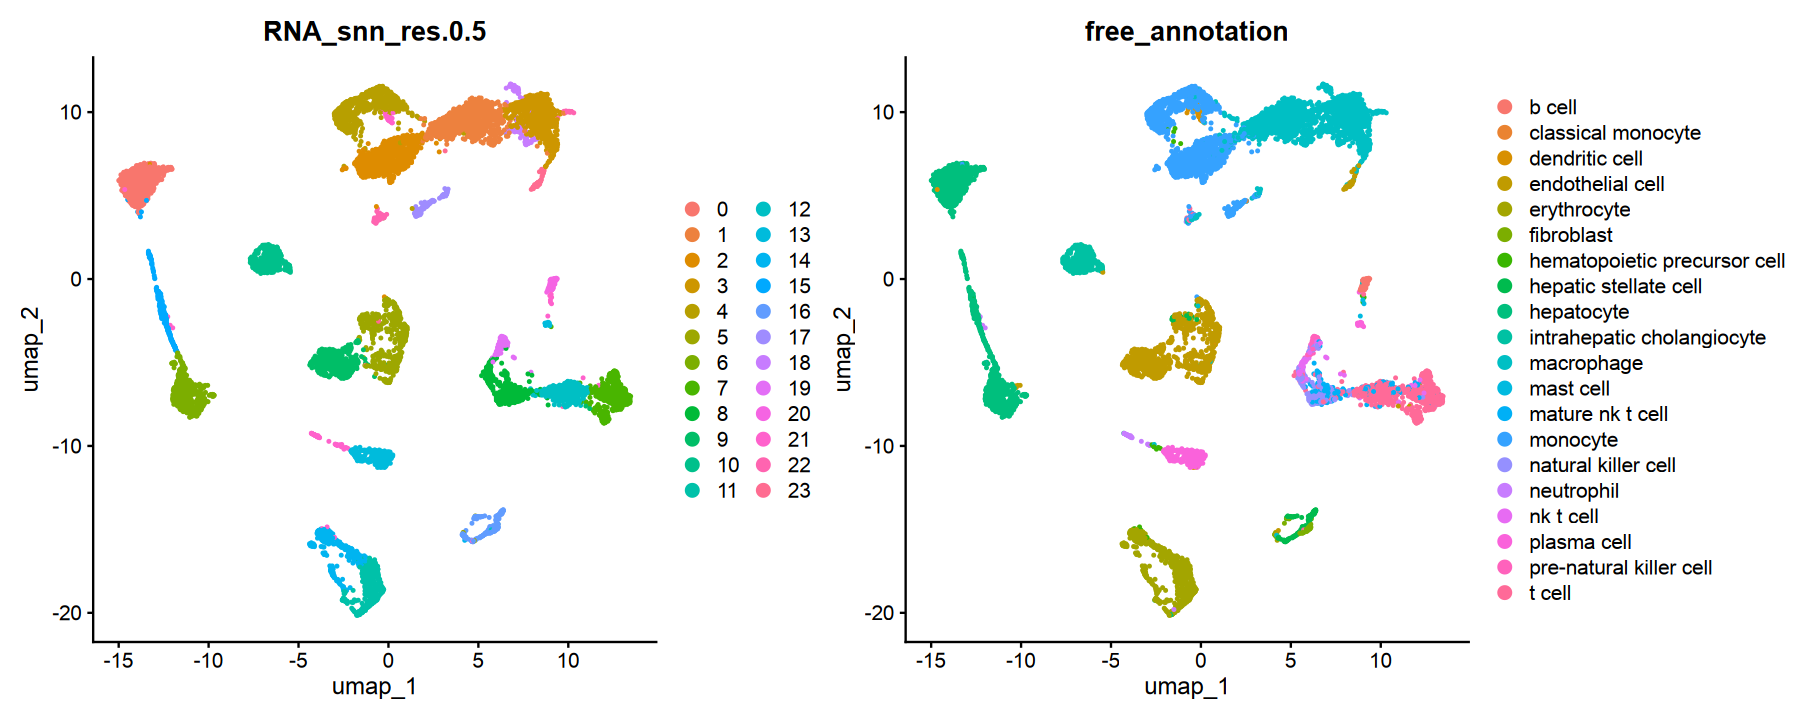

In [15]:
p1 <- DimPlot(ref_obj, reduction = "umap", group.by = "RNA_snn_res.0.5", pt.size = 0.2)
p2 <- DimPlot(ref_obj, reduction = "umap", group.by = "free_annotation", pt.size = 0.2)
options(repr.plot.width = 15, repr.plot.height = 6)
p1 + p2
# To increase the overall width in Jupyter, you can also set the output display width:
# options(repr.plot.width = 16)

In [16]:
xenium_path <- "/home/gddaslab/mxp140/xenium_liver_cancer/xenium_data/diseased/liver_cancer_data.h5ad"
xenium_sce <- zellkonverter::readH5AD(xenium_path, verbose = TRUE)
xenium_sce

ℹ Using the Python reader

ℹ Using anndata version 0.10.2

⠙ Reading '/.../.../.../.../.../.../liver_cancer_data.h5ad '

✔ Read /.../.../.../.../.../.../liver_cancer_data.h5ad s]



ℹ Converting AnnData to SingleCellExperiment

ℹ uns is empty and was skipped

ℹ Converting AnnData to SingleCellExperiment
ℹ Converting X matrix to assay

✔ X matrix converted to assay s]



ℹ Converting AnnData to SingleCellExperiment
ℹ Converting layers to assays

ℹ Converting layers$raw_counts

✔ layers$raw_counts converted s]



ℹ Converting layers to assays
✔ Converting layers to assays ... done



ℹ Converting AnnData to SingleCellExperiment
ℹ Converting var to rowData

✔ var converted to rowData s]



ℹ Converting AnnData to SingleCellExperiment
ℹ Converting obs to colData

✔ obs converted to colData s]



ℹ Converting AnnData to SingleCellExperiment
ℹ varm is empty and was skipped

ℹ Converting AnnData to SingleCellExperiment
ℹ obsm is empty and was skipped

ℹ Converting AnnData to SingleCellExperim

class: SingleCellExperiment 
dim: 474 162628 
metadata(0):
assays(2): X raw_counts
rownames(474): 0 1 ... 472 473
rowData names(8): ensembl_id gene_symbol ... total_counts
  log1p_total_counts
colnames(162628): 0 1 ... 162626 162627
colData names(8): total_transcripts n_genes_by_counts ...
  pct_counts_in_top_50_genes pct_counts_in_top_100_genes
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [17]:
xenium_obj <- as.Seurat(xenium_sce, counts = "X", data = "raw_counts")
counts <- GetAssayData(xenium_obj, layer = "counts")
ensembl_ids <- rowData(xenium_sce)$ensembl_id
rownames(counts) <- ensembl_ids
xenium_obj <- CreateSeuratObject(counts = counts)

In [18]:
xenium_obj

An object of class Seurat 
474 features across 162628 samples within 1 assay 
Active assay: RNA (474 features, 0 variable features)
 1 layer present: counts

In [19]:
print(median(xenium_obj@meta.data$nCount_RNA))
print(median(xenium_obj@meta.data$nFeature_RNA))

[1] 114
[1] 60


In [20]:
xenium_obj <- NormalizeData(xenium_obj) %>%
              FindVariableFeatures() %>%
              ScaleData() %>%
              RunPCA(verbose=F) %>%
              RunUMAP(dims=1:15) %>%
              FindNeighbors(dims=1:15) %>%
              FindClusters(resolution=0.5)


Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

14:54:36 UMAP embedding parameters a = 0.9922 b = 1.112

14:54:36 Read 162628 rows and found 15 numeric columns

14:54:36 Using Annoy for neighbor search, n_neighbors = 30

14:54:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:54:51 Writing NN index file to temp file /tmp/RtmpZwgK07/file12b0b6499b2765

14:54:51 Searching Annoy index using 1 thread, search_k = 3000

14:56:09 Annoy recall = 100%

14:56:10 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:56:19 Initializing from normalized Laplacian + noise (using RSpectra)

14:56:27 Commencing optimization for 200 epochs, with 7318258 positive edges

14:56:27 Using rng 

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 162628
Number of edges: 4176874

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8896
Number of communities: 13
Elapsed time: 116 seconds


In [21]:
xenium_obj

An object of class Seurat 
474 features across 162628 samples within 1 assay 
Active assay: RNA (474 features, 474 variable features)
 3 layers present: counts, data, scale.data
 2 dimensional reductions calculated: pca, umap

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



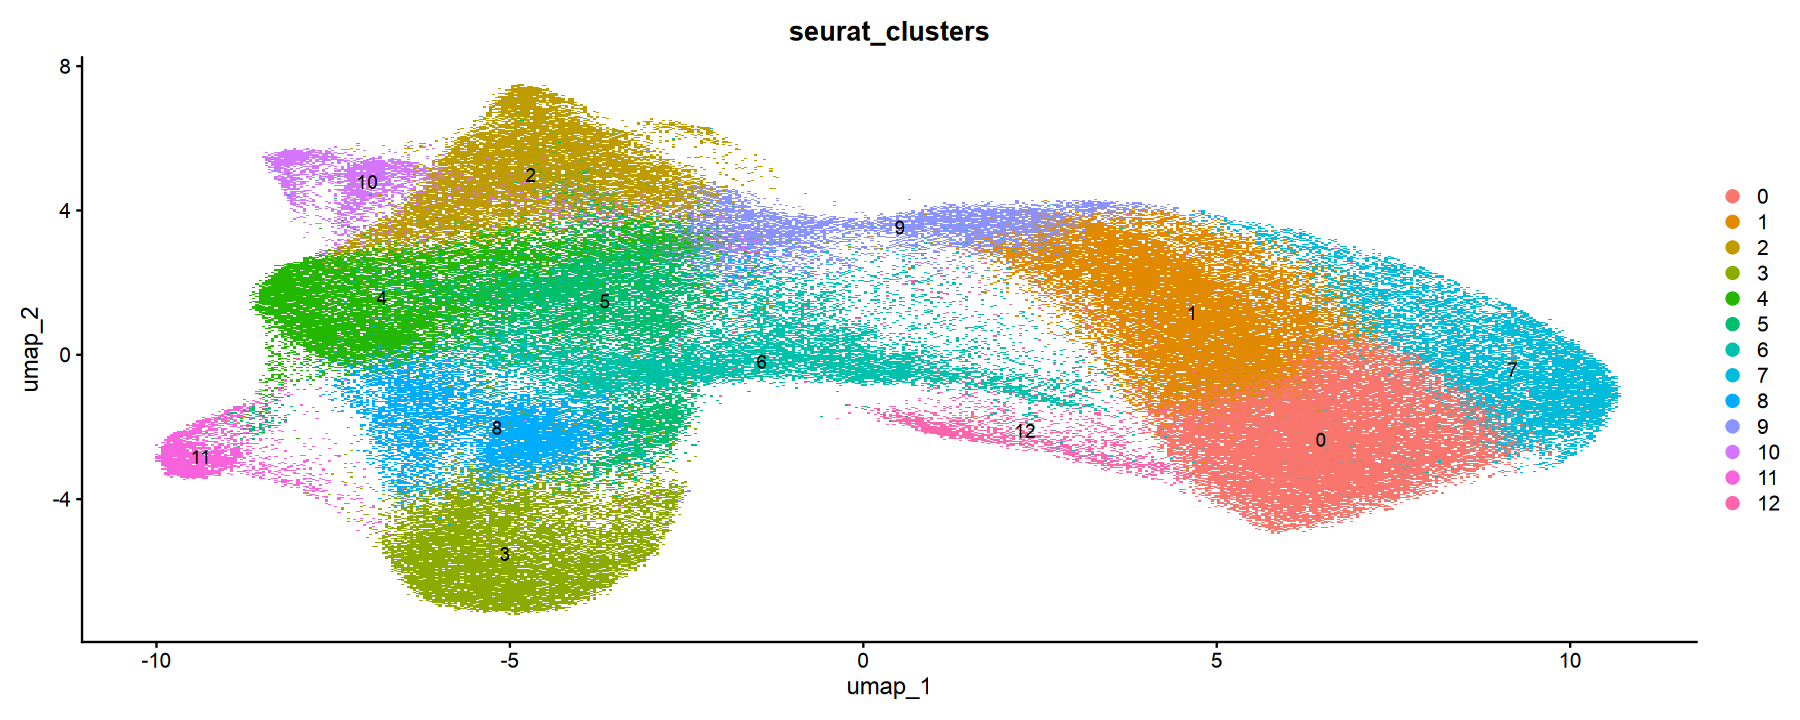

In [22]:
DimPlot(xenium_obj, group.by = "seurat_clusters", label=T, label.size = 4)

In [23]:
anchors <- FindTransferAnchors(reference = ref_obj, query = xenium_obj, dims = 1:30)

Performing PCA on the provided reference using 187 features as input.

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 11032 anchors



In [24]:
label_transfer <- TransferData(anchorset = anchors, 
                            refdata = ref_obj$free_annotation,
                            dims = 1:30)

Finding integration vectors

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.
ℹ The deprecated feature was likely used in the Seurat package.
  Please report the issue at <https://github.com/satijalab/seurat/issues>.”
Finding integration vector weights

Predicting cell labels



In [25]:
xenium_obj <- AddMetaData(object = xenium_obj, metadata = label_transfer, col.name = 'predicted.id')

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



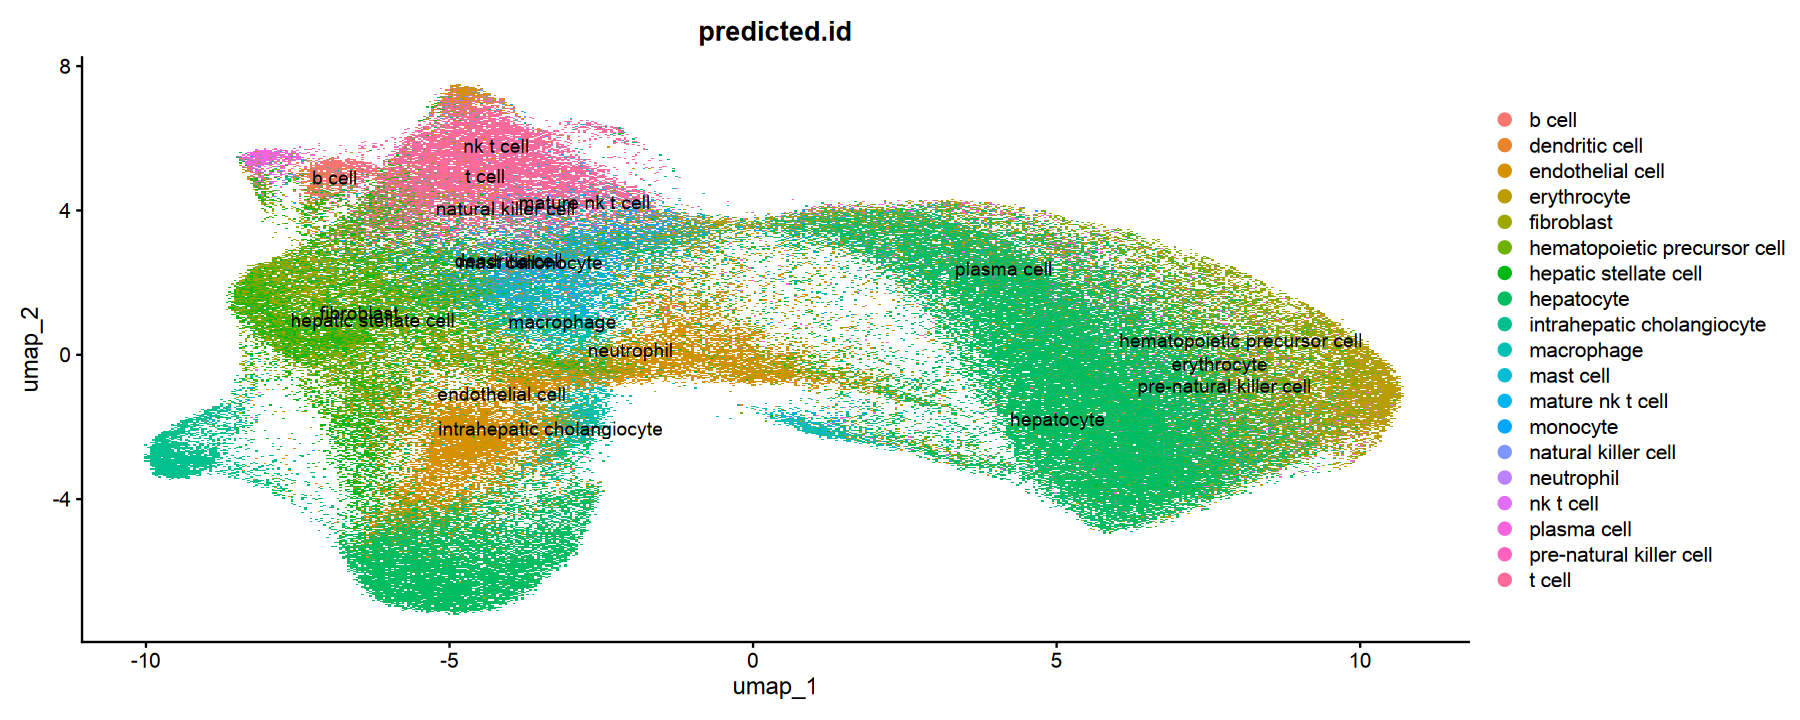

In [26]:
DimPlot(xenium_obj, group.by = "predicted.id", label=T, label.size = 4)

In [39]:
colData(xenium_sce)$seurat_prediction <- xenium_obj@meta.data$predicted.id

In [ ]:
xenium_obj@meta.data$seurat_clusters

In [48]:
predicted_id_df <- data.frame(seurat_clusters = xenium_obj@meta.data$seurat_clusters, seurat_prediction = xenium_obj@meta.data$predicted.id)
head(predicted_id_df)

,seurat_clusters,seurat_prediction
,<fct>,<chr>
1,9,erythrocyte
2,9,hepatocyte
3,9,erythrocyte
4,9,erythrocyte
5,9,erythrocyte
6,9,erythrocyte


In [52]:
write.csv(predicted_id_df, "seurat_clusters_and_predictions.csv", row.names=FALSE)